<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Forecasting - Previsões Para Séries Temporais - Exponential Smoothing</font></b></strong>

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime
#from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
#plt.style.use('fivethirtyeight')
#m.rcParams['axes.labelsize'] = 14
#m.rcParams['xtick.labelsize'] = 12
#m.rcParams['ytick.labelsize'] = 12
#m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy      : 1.19.5
pandas     : 1.2.4
sklearn    : 1.1.1
sys        : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
matplotlib : 3.3.4
statsmodels: 0.12.2



## Definição do Problema de Negócio

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

In [3]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)

# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

filtro1 = dataframe['Broker']=='ETB170'
filtro2 = dataframe['Service_name']=='PORTALDETRAN'
filtro3 = dataframe['Programa']=='NSDGX500'
dataframe = dataframe[filtro1 & filtro2 & filtro3]

dataframe = dataframe.rename_axis('index').reset_index()
dataframe.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

dataframe.drop_duplicates(subset='Data', inplace=True)
dataframe = dataframe.set_index('Data')
dataframe = dataframe.resample('D').interpolate()

In [4]:
# Dados
dataframe.head()

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0


In [5]:
dataframe.index

DatetimeIndex(['2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29',
               '2021-10-30', '2021-10-31', '2021-11-01', '2021-11-02',
               '2021-11-03', '2021-11-04',
               ...
               '2022-10-16', '2022-10-17', '2022-10-18', '2022-10-19',
               '2022-10-20', '2022-10-21', '2022-10-22', '2022-10-23',
               '2022-10-24', '2022-10-25'],
              dtype='datetime64[ns]', name='Data', length=365, freq='D')

In [6]:
# Tipos de dados
dataframe.dtypes

Quantidade    float64
dtype: object

In [7]:
# Shape
dataframe.shape

(365, 1)

In [8]:
dataframe.describe()

,Quantidade
count,365.000000
mean,113.072603
std,69.687170
min,3.000000
25%,55.500000
50%,110.000000
75%,162.000000
max,336.000000


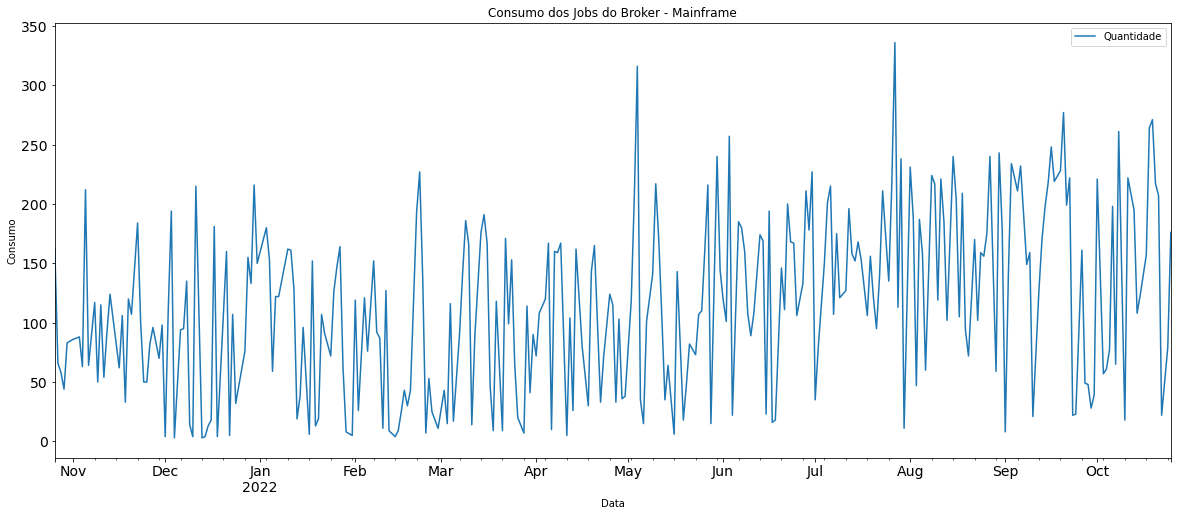

In [8]:
# Plot
dataframe.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

In [ ]:
# Média móvel de 30 dias

rolmean = dataframe.rolling(window = 30).mean()

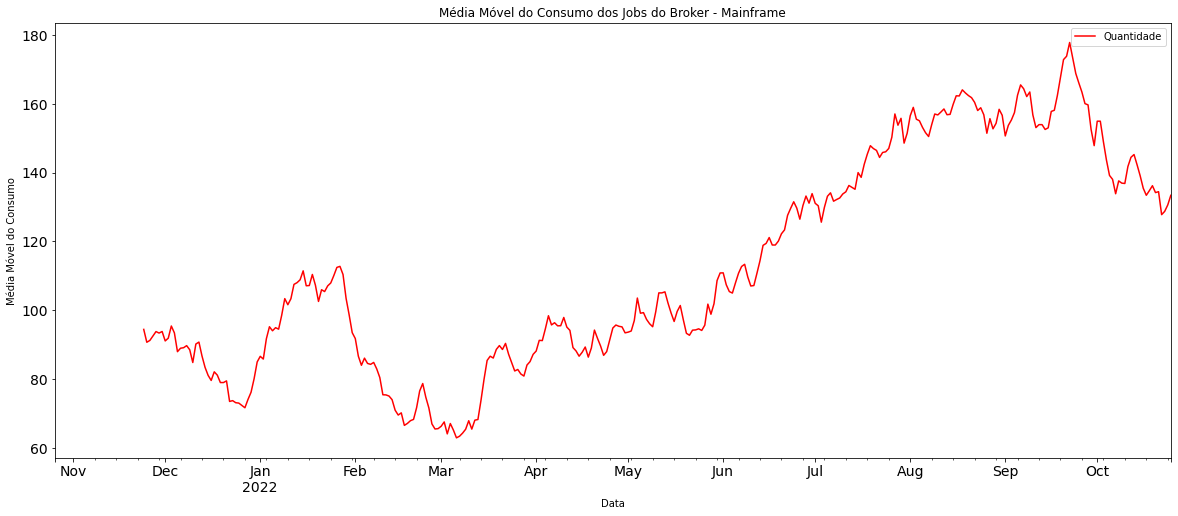

In [29]:
# Plot
rolmean.plot(title = 'Média Móvel do Consumo dos Jobs do Broker - Mainframe', fontsize = 14, 
             label = 'Consumo do Broker', color = 'red') 
plt.xlabel("Data") 
plt.ylabel("Média Móvel do Consumo") 
plt.legend(loc = 'best') 
plt.show()

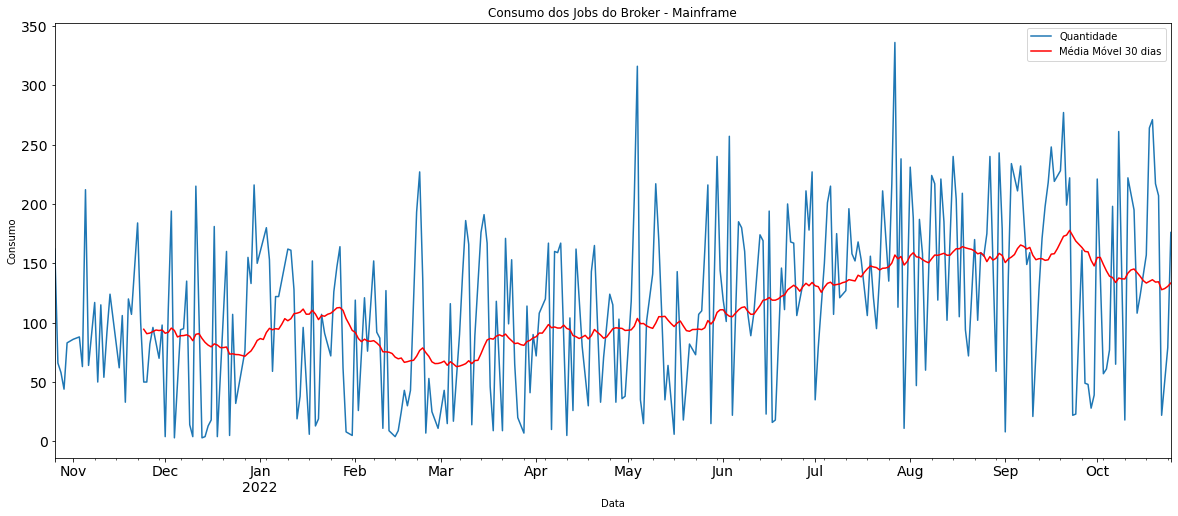

In [30]:
# Plot
dataframe.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.plot(rolmean, label = 'Média Móvel 30 dias', color = 'red')
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

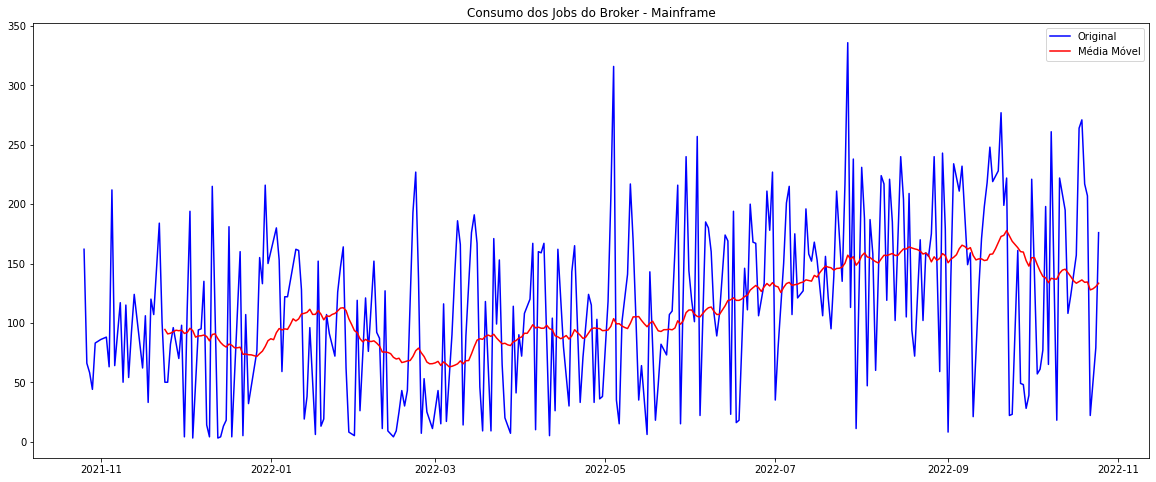

In [31]:
# Plot
orig = plt.plot(dataframe['Quantidade'], color = 'blue', label = 'Original')
mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
plt.legend(loc = 'best') 
plt.title('Consumo dos Jobs do Broker - Mainframe')
plt.show()

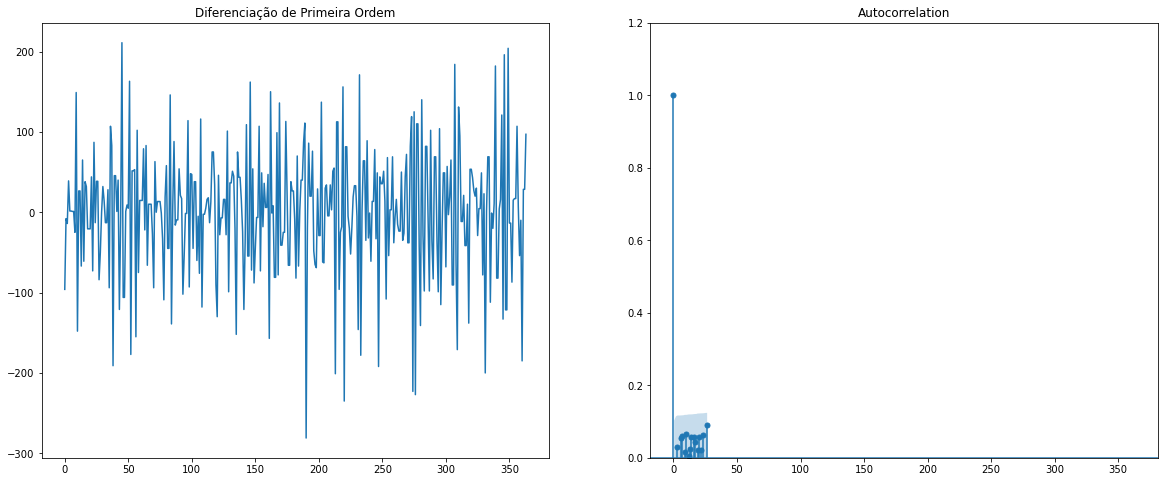

In [32]:
# Gráfico ACF
fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(np.diff(target.values)); axes[0].set_title('Diferenciação de Primeira Ordem')
axes[1].set(ylim = (0,1.2))
plot_acf(np.diff(target.values), ax = axes[1])
plt.show()

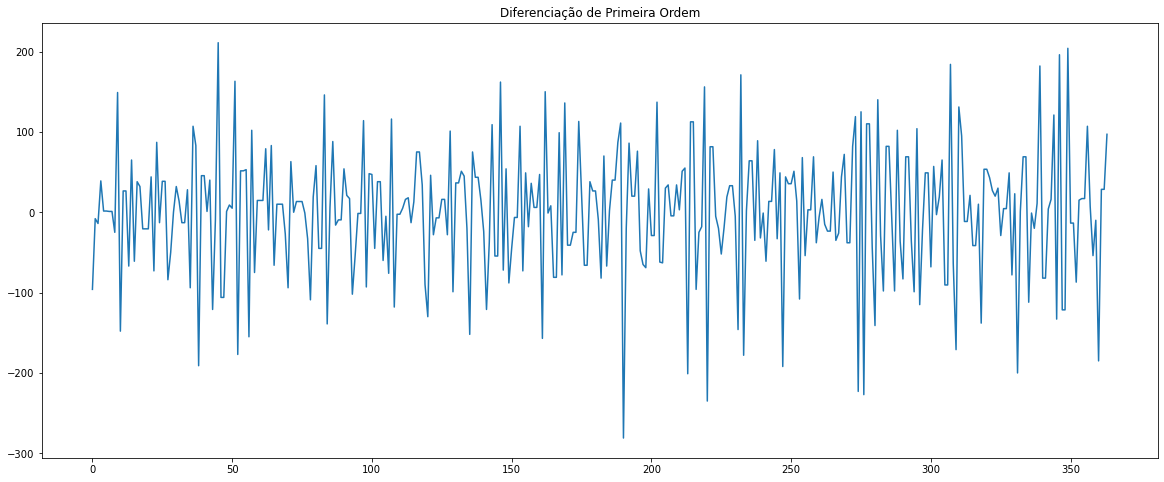

In [35]:
# Gráfico ACF
plt.plot(np.diff(target.values))
plt.title('Diferenciação de Primeira Ordem')
plt.show()

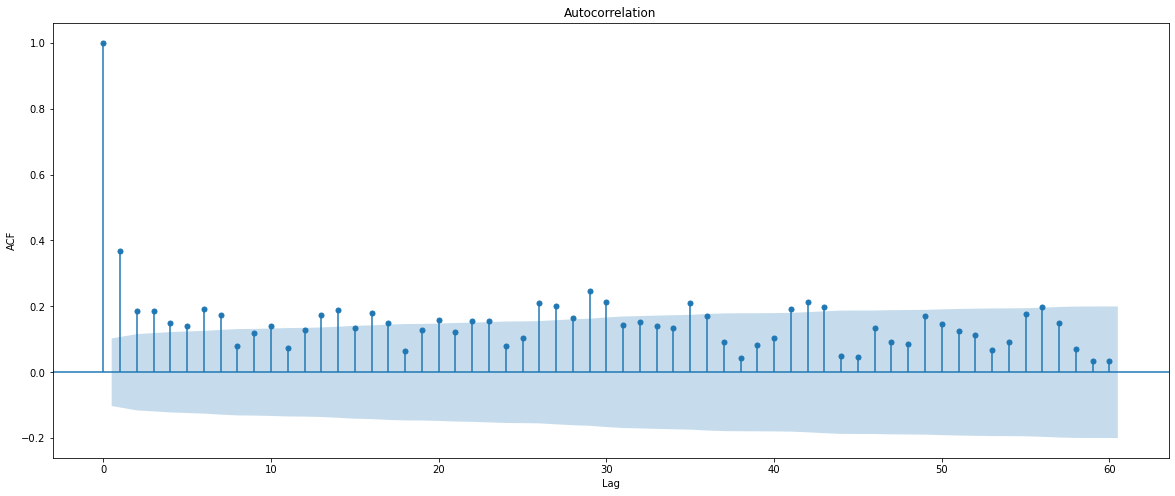

In [36]:
plot_acf(target.values,lags=60)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

## ACF medição da autocorrelação entre períodos anteriores com o período atual (lags)

## Para haver auto correlação com a lag anterior os valores devem estar FORA da faiza azul (intervalo de confiaça)

## Se todos os valores estiverem DENTRO da faixa azul temos o ruído branco ou passeio aleatório onde não há auto correlação

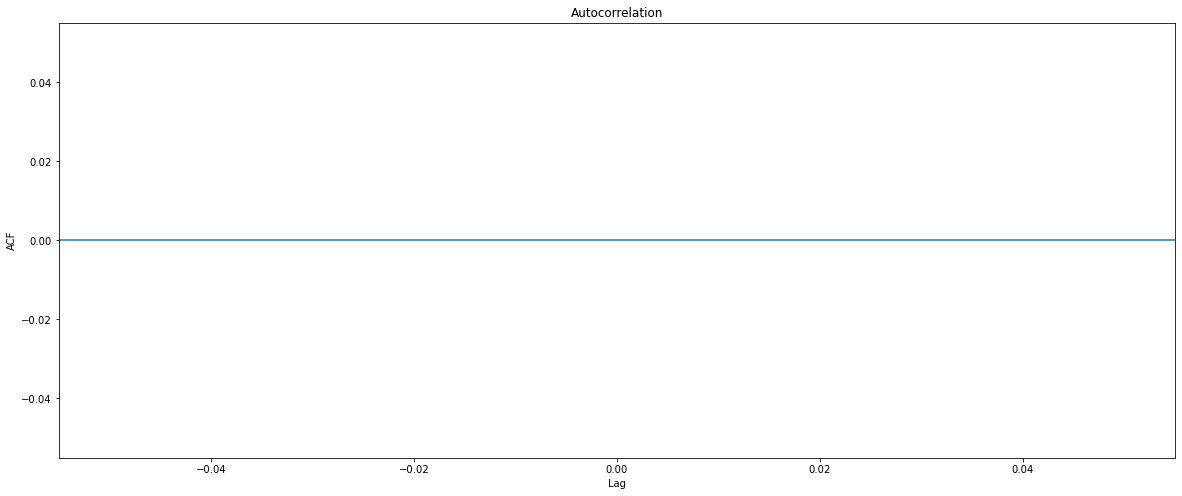

In [11]:
plot_acf(rolmean.values,lags=60)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

In [11]:
# Refinamos os dados para o gráfico da série original

# A variável Quantidade é nossa variável target (Consumo dos Jobs do Broker)
target = dataframe['Quantidade']

In [12]:
import scipy.stats as stats

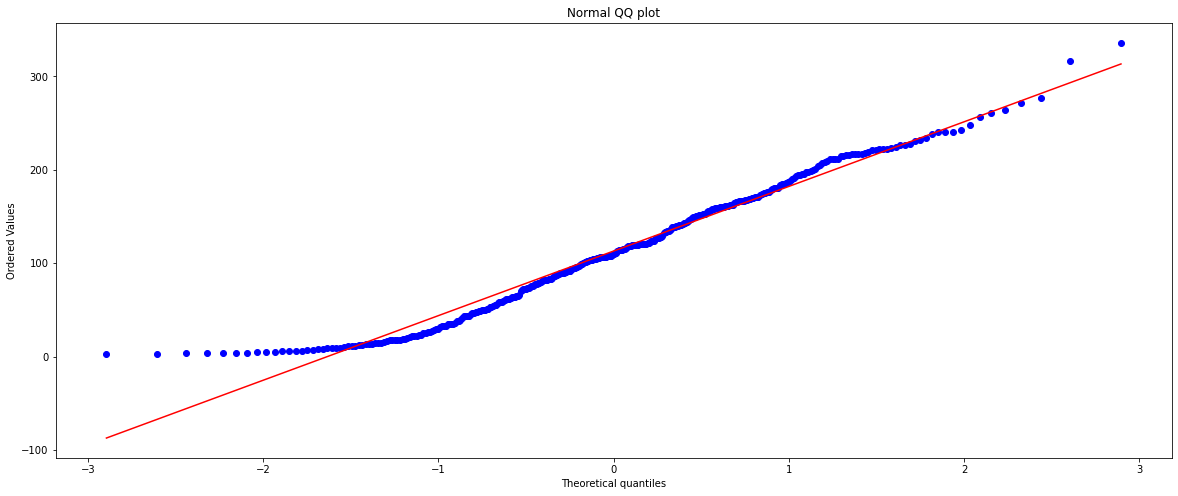

In [13]:
stats.probplot(target, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

**Teste Shapiro-Wilk**

CRITÉRIOS:

NÍVEL DE SIGNIFICÂNCIA DE 0,05 ou 5% (MAIS UTILIZADO)

QUANDO p > 0,05 (distribuição normal).

In [14]:
e, p = stats.shapiro(target)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9722642302513123
p-valor: 1.896342382678995e-06


In [13]:
# Random seed 
np.random.seed(7)

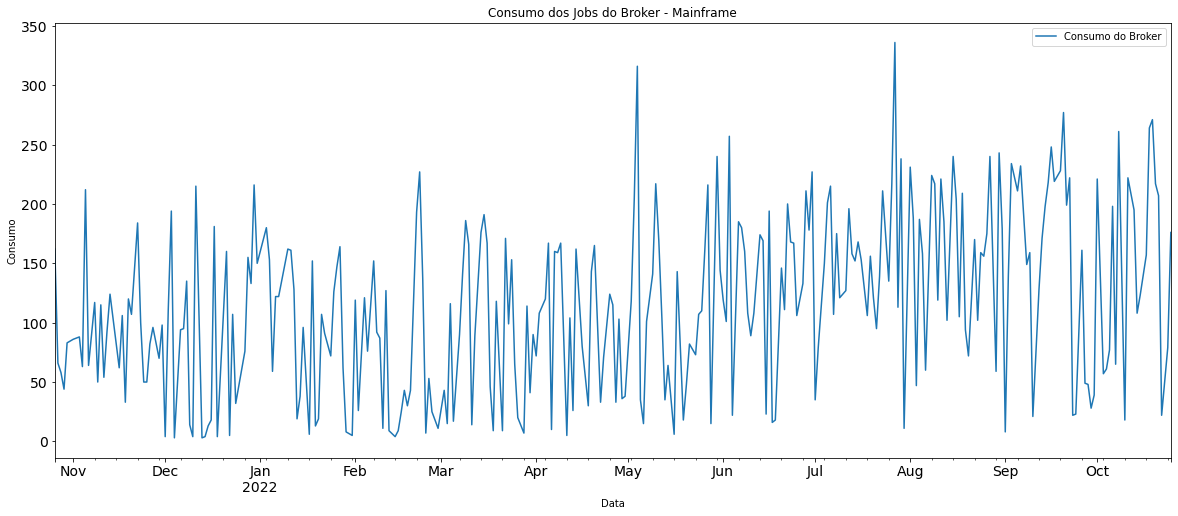

In [14]:
# Plot
target.plot(title = 'Consumo dos Jobs do Broker - Mainframe', fontsize = 14, label = 'Consumo do Broker') 
plt.xlabel("Data") 
plt.ylabel("Consumo") 
plt.legend(loc = 'best') 
plt.show()

Vamos testar a estacionaridade da série.

In [15]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 10).mean()
    rolstd = serie.rolling(window = 10).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

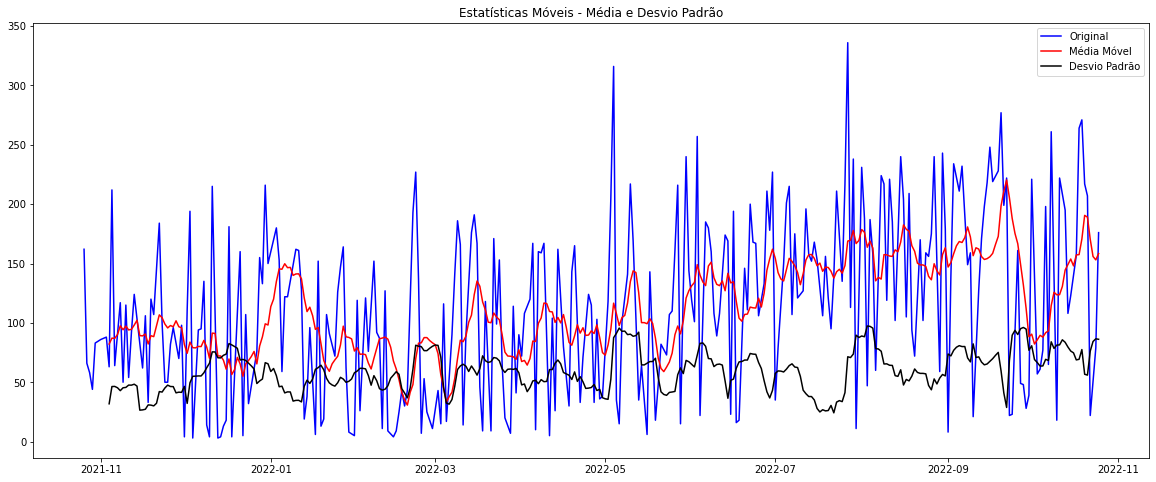


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -5.155394
Valor-p                           0.000011
Número de Lags Consideradas       5.000000
Número de Observações Usadas    359.000000
Valor Crítico (1%)               -3.448697
Valor Crítico (5%)               -2.869625
Valor Crítico (10%)              -2.571077
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [16]:
# Aplica a função 
testa_estacionaridade(dataframe['Quantidade'])

In [23]:
# Função para testar a estacionaridade
def testa_estacionaridade30(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 30).mean()
    rolstd = serie.rolling(window = 30).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

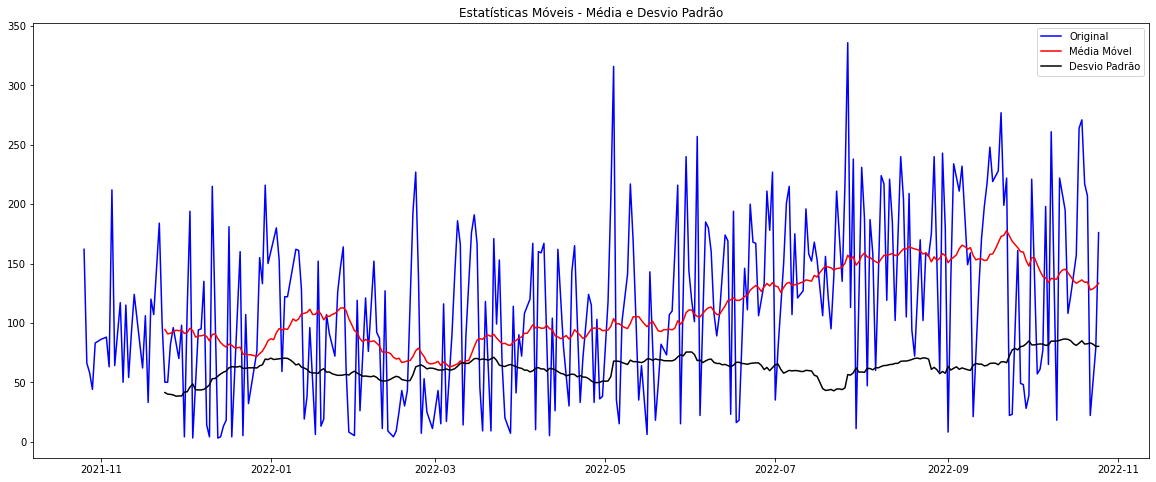


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -5.155394
Valor-p                           0.000011
Número de Lags Consideradas       5.000000
Número de Observações Usadas    359.000000
Valor Crítico (1%)               -3.448697
Valor Crítico (5%)               -2.869625
Valor Crítico (10%)              -2.571077
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [24]:
# Aplica a função 
testa_estacionaridade30(dataframe['Quantidade'])

A série já é estacionária.

Vamos decompor a série e analisar seus componentes em separado.

In [25]:
# Decompondo a série temporal
decomposition = seasonal_decompose(dataframe['Quantidade'])

In [26]:
# Extraindo cada componente da série
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

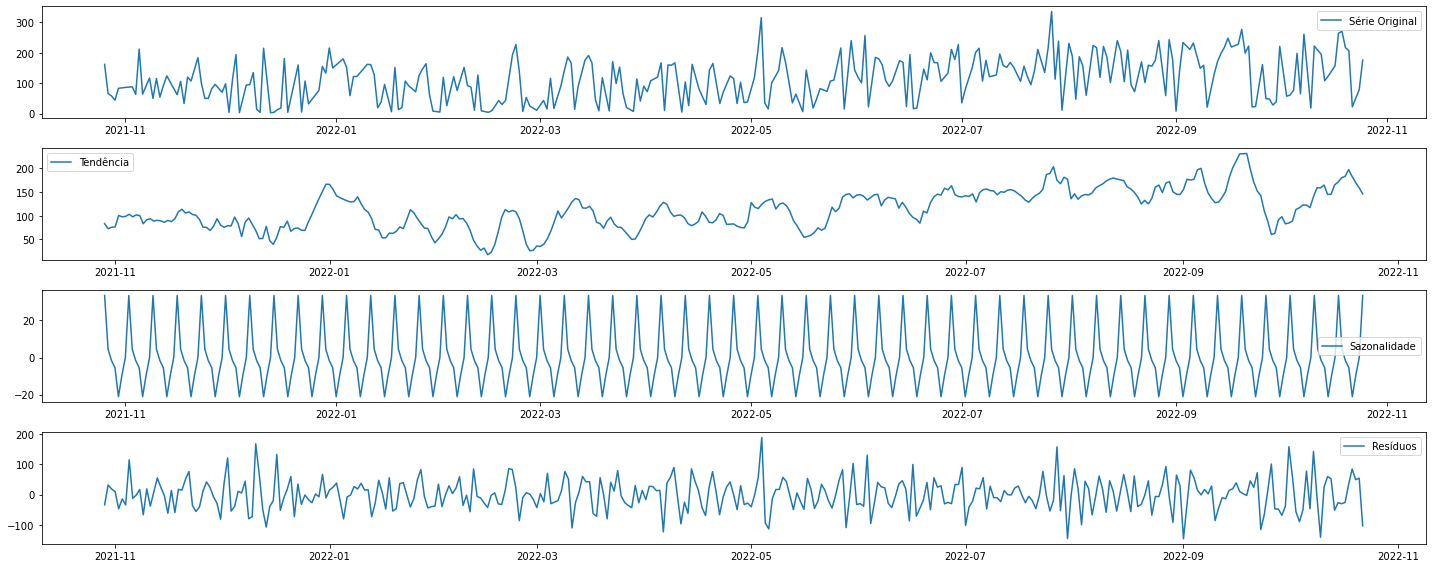

In [27]:
# Plot
plt.subplot(411)
plt.plot(dataframe['Quantidade'], label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal,label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

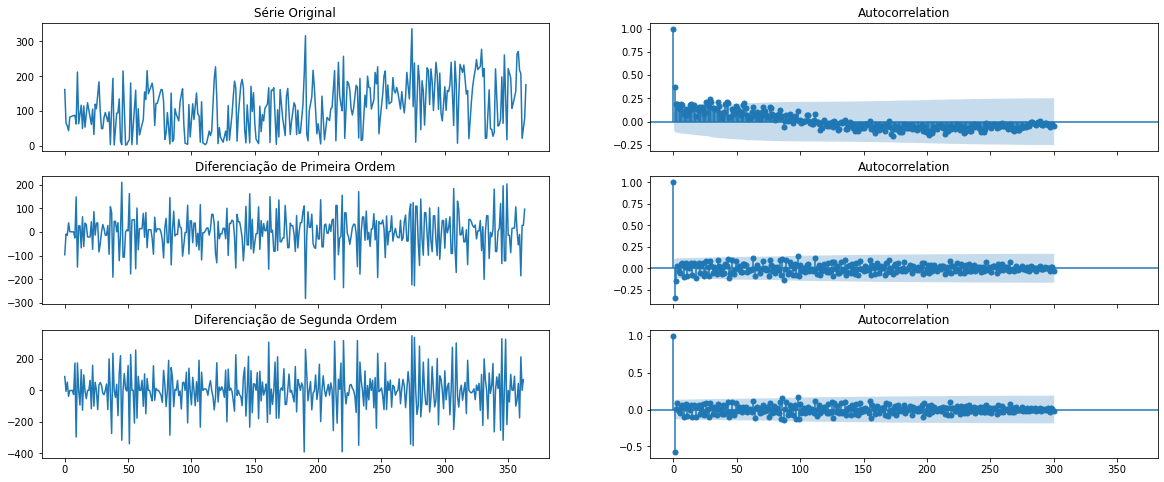

In [28]:
# Área de Plotagem
fig, axes = plt.subplots(3, 2, sharex = True)

# Série Original
axes[0, 0].plot(target.values); axes[0, 0].set_title('Série Original')
plot_acf(target.values, lags = 300, ax = axes[0, 1])

# Diferenciação de Primeira Ordem
axes[1, 0].plot(np.diff(target.values)); axes[1, 0].set_title('Diferenciação de Primeira Ordem')
plot_acf(np.diff(target.values), lags = 300, ax = axes[1, 1])

# Diferenciação de Segunda Ordem
axes[2, 0].plot(np.diff(np.diff(target.values))); axes[2, 0].set_title('Diferenciação de Segunda Ordem')
plot_acf(np.diff(np.diff(target.values)), lags = 300, ax = axes[2, 1])

plt.show()

# Fim